In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense

%matplotlib inline

In [2]:
def load_mnist_data():
    (xTrain, yTrain),  (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255
    xTest = xTest.astype('float32') / 255

    width, height = xTrain.shape[1], xTrain.shape[2]
    xTrain = xTrain.reshape((xTrain.shape[0], width, height, 1))
    xTest = xTest.reshape((xTest.shape[0], width, height, 1))

    return xTrain, yTrain, xTest, yTest


def display_random_set(data, labels):
    for i in range(8):
        rand_val = np.random.randint(low=0, high=len(data))
        plt.subplot(2, 4, (i + 1))
        plt.imshow(data[rand_val], cmap='gray')
        plt.title(str(labels[rand_val]))
        plt.axis(False)
    plt.show()


def build_model(num_classes, img_dimension):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu', input_shape=img_dimension))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print(model.summary())

    return model


def train_model(x_train, y_train_cat, x_test, y_test_cat, classes, epochs, batch_size, training=False):
    if training:
        model = build_model(num_classes=len(classes), img_dimension=x_test[0].shape)
        checkpoint = ModelCheckpoint(filepath='mnist_checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True)

        history = model.fit(x=x_train, y=y_train_cat, batch_size=batch_size, epochs=epochs, verbose=2, callbacks=[checkpoint],
                            validation_data=(x_test, y_test_cat), shuffle=True)

        print('[Saved] Saved model...')

        save_history_file(file_name='mnist_model.pickle', history=history)
        print('[Done] History file saved as pickle file...')


def evaluate_and_visualize_model_performance(classifier, pickle_file, validation_set):
    x_cv, y_cv = validation_set
    scores = classifier.evaluate(x_cv, y_cv, verbose=0)
    print('Model Classifier Accuracy: {} %'.format(scores[1] * 100))

    y_prediction = classifier.predict_classes(x_cv, verbose=0)
    y_actual = [np.argmax(actual) for actual in y_cv]

    plt.figure(figsize=(10, 7))
    for i in range(10):
        random_val = np.random.randint(low=0, high=len(x_cv))
        plt.subplot(2, 5, (i + 1))
        plt.imshow(x_cv[random_val], cmap='gray')
        plt.title("Actual:{}, Pred:{}".format(y_actual[random_val], y_prediction[random_val]))
        plt.axis(False)
    plt.show()

    plt.figure()
    plt.plot(pickle_file['loss'])
    plt.plot(pickle_file['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlim([-2, 22])
    plt.show()


def save_history_file(file_name, history):
    pickle_out = open(file_name, 'wb')
    pickle.dump(history.history, pickle_out)
    pickle_out.close()


def load_history(file_name):
    pickle_in = open(file_name, 'rb')
    saved_history = pickle.load(pickle_in)
    return saved_history

In [3]:
def main():
    x_train, y_train, x_test, y_test = load_mnist_data()

    print(f"Training Data shape: {x_train.shape}    Labels shape: {y_train.shape}")
    print(f"Testing Data shape: {x_test.shape}    Labels shape: {y_test.shape}")

    display_random_set(x_train, y_train)

    classes = np.unique(y_train)    # Labels
    y_train_cat = to_categorical(y=y_train)
    y_test_cat = to_categorical(y=y_test)

    # Using 2000 images for validation and 8000 images for testing data
    x_test, x_cv, y_test_cat, y_cv = train_test_split(x_test, y_test_cat, test_size=0.2, random_state=42, shuffle=True)

    epochs = 20
    batch_size = 256
    train_model(x_train=x_train, y_train_cat=y_train_cat, x_test=x_test, y_test_cat=y_test_cat, classes=classes,
                epochs=epochs, batch_size=batch_size, training=False)

    loaded_history = load_history(file_name='mnist_model.pickle')
    print('[Done] History file loaded...')
    classifier = load_model(filepath='mnist_checkpoint.h5')
    print('[Done] classifier loaded...')

    evaluate_and_visualize_model_performance(classifier=classifier, pickle_file=loaded_history, validation_set=(x_cv, y_cv))

Training Data shape: (60000, 28, 28, 1)    Labels shape: (60000,)
Testing Data shape: (10000, 28, 28, 1)    Labels shape: (10000,)


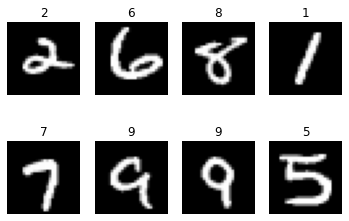

[Done] History file loaded...
[Done] classifier loaded...
Model Classifier Accuracy: 98.94999861717224 %


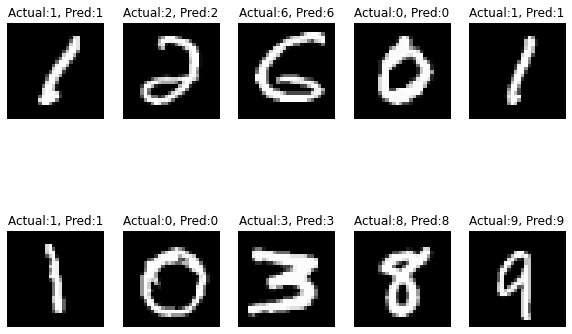

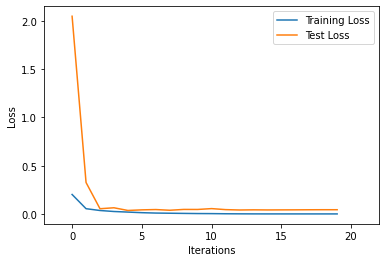

In [4]:
main()